<a href="https://colab.research.google.com/github/ajinkyabhanudas/SIADS696/blob/dev/Modeling_phase2_Ajinkya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling
### (This notebook) Model Modeling Phase 2/2:
The purpose of the next notebook will be to:
- pick the top 3 best performing models across different families of algorithms.
- Compare the top 3 to their own default versions to document performance improvements.
- Identifying best/worst performing feature choices across all the chosen models.

In [1]:
# !git clone https://github.com/ajinkyabhanudas/SIADS696.git
!pip install gensim==4.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 53.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [17]:
!gdown 1PTaSiunxWhwkHxKf5v4G3oPbAXzvGqKN 
!gdown 1v8rbzAcb_cAw7kwShlGyEuAUw2Ja006N 
!gdown 1porOGWPwFdydbXbQQmveCPvAT1lvO8RC
!gdown 12uI3sXRLJzEwPx05D7tZD5g7DRAcAcFs

!gdown 1kC-qXhqYub06eleoXyt8lOMUnpjwBhVv

Downloading...
From: https://drive.google.com/uc?id=1PTaSiunxWhwkHxKf5v4G3oPbAXzvGqKN
To: /content/train_X.csv
100% 39.6M/39.6M [00:00<00:00, 71.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1v8rbzAcb_cAw7kwShlGyEuAUw2Ja006N
To: /content/train_y.csv
100% 733k/733k [00:00<00:00, 103MB/s]
Downloading...
From: https://drive.google.com/uc?id=1porOGWPwFdydbXbQQmveCPvAT1lvO8RC
To: /content/test_X.csv
100% 9.92M/9.92M [00:00<00:00, 24.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=12uI3sXRLJzEwPx05D7tZD5g7DRAcAcFs
To: /content/test_y.csv
100% 183k/183k [00:00<00:00, 73.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kC-qXhqYub06eleoXyt8lOMUnpjwBhVv
To: /content/model_results.csv
100% 940/940 [00:00<00:00, 1.47MB/s]


In [9]:
import datetime
import enum
import glob
import json
import os
import re
from itertools import groupby

from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from matplotlib import ticker

import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import pickle

import warnings
warnings.simplefilter(action='ignore')

In [10]:
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import DBSCAN

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [11]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor, SGDRegressor
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import r2_score

from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV

In [133]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.inspection import permutation_importance


from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

In [13]:
import gensim.downloader
glove_wv = gensim.downloader.load('glove-wiki-gigaword-50')

nltk.download('punkt')
nltk.download('stopwords')

[==================================================] 100.0% 66.0/66.0MB downloaded


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [40]:
train_X = pd.read_csv("train_X.csv")
train_y = pd.read_csv("train_y.csv")

test_X = pd.read_csv("test_X.csv")
test_y = pd.read_csv("test_y.csv")

model_results  = pd.read_csv("model_results.csv")

In [59]:
def ret_metrics(model, test_X=test_X, test_y=test_y):

  pred = model.predict(test_X)
  mae = metrics.mean_absolute_error(test_y, pred)
  mse = metrics.mean_squared_error(test_y, pred)
  rmse = np.sqrt(mse)

  return(mae, mse, rmse)

def model_train(model, parameters=None, train_X=train_X):
  
  if parameters:
    model = GridSearchCV(model, parameters, cv=3)
  
  model.fit(train_X, train_y)

  return(model)

In [41]:
model_names = ['dummy_regressor', 'linear_regressor', 'sgd_regressor',
               'elasticnet', 'decision_tree', 'random_forest',
               'hist_grad_boosting']
model_names_dict = {k:v for v, k in zip(model_names, model_results.model)}

In [42]:
view_res_df = model_results.copy()
view_res_df['model'] = view_res_df.model.map(model_names_dict)
view_res_df#style.background_gradient().set_precision(4)

,model,r2,mae,mse,rmse
0,dummy_regressor,-0.0000,1.6238,5.5187,2.3492
1,linear_regressor,0.1033,1.5427,4.9488,2.2246
2,sgd_regressor,-116769122108642481405952.0000,1.5427,4.9488,2.2246
3,elasticnet,0.0713,1.5690,5.1255,2.2640
4,decision_tree,0.2876,1.3394,3.9314,1.9828
5,random_forest,0.3118,1.3540,3.7980,1.9489
6,hist_grad_boosting,0.3720,1.2784,3.5881,1.8942


In [49]:
model_results = model_results.sort_values(['r2', 'mae', 'rmse'], ascending=[False, True, True])

In [78]:
model_results.iloc[1].model ##.model[:2].values

'HistGradientBoostingRegressor(l2_regularization=0.2, max_depth=10,\n                              max_leaf_nodes=50, n_iter_no_change=15,\n                              validation_fraction=0.2)'

We'll be taking our final model analysis further with these top 2 models.
Before we get there, Even though we benchmarked the need for higher degree polynomials, let's quickly do a valdiation against their counterparts with degree 1.

### Validating the need for degree 1,5,15 polynomials

In [54]:
ct = ColumnTransformer(
    [("ohe", OneHotEncoder(handle_unknown='ignore'), ["definition", "topicLabel"]),
    ("poly", PolynomialFeatures(15),["publishedDayNum",	"log_duration_secs", "len_title"]),
    ], remainder="passthrough")

train_X15 = ct.fit_transform(train_X)
test_X15 = ct.transform(test_X)

mms = StandardScaler()
train_X15 = mms.fit_transform(train_X15)
test_X15 = mms.transform(test_X15)

In [55]:
train_X15.shape

(38435, 879)

In [56]:
ct = ColumnTransformer(
    [("ohe", OneHotEncoder(handle_unknown='ignore'), ["definition", "topicLabel"]),
    ("poly", PolynomialFeatures(1),["publishedDayNum",	"log_duration_secs", "len_title"]),
    ], remainder="passthrough")

train_X1 = ct.fit_transform(train_X)
test_X1 = ct.transform(test_X)

mms = StandardScaler()
train_X1 = mms.fit_transform(train_X1)
test_X1 = mms.transform(test_X1)

In [57]:
train_X1.shape

(38435, 67)

In [79]:
models = [DummyRegressor(), LinearRegression(),SGDRegressor(), ElasticNet(alpha=0, l1_ratio=0),
          DecisionTreeRegressor(max_depth=10), RandomForestRegressor(max_depth=10, n_estimators=50, oob_score=True),
          HistGradientBoostingRegressor(l2_regularization=0.2, max_depth=10, max_leaf_nodes=50, n_iter_no_change=15)]

In [83]:
poly_features_mae = {'model':[], 'poly1_mae':[], 'poly15_mae':[]}
poly_features_mse = {'model':[], 'poly1_mse':[], 'poly15_mse':[]}
poly_features_rmse = {'model':[], 'poly1_rmse':[], 'poly15_rmse':[]}

for model in models:
  m1 = model
  
  m1.fit(train_X1, train_y)

  poly_features_mae['model'].append(m1)
  poly_features_mse['model'].append(m1)
  poly_features_rmse['model'].append(m1)

  a1, s1, rs1 = ret_metrics(m1, train_X1, train_y)

  poly_features_mae['poly1_mae'].append(a1)
  poly_features_mse['poly1_mse'].append(s1)
  poly_features_rmse['poly1_rmse'].append(rs1)

for model in models:
  m15 = model
  
  m15.fit(train_X15, train_y)

  a15, s15, rs15 = ret_metrics(m15, train_X15, train_y)
  
  poly_features_mae['poly15_mae'].append(a15)
  poly_features_mse['poly15_mse'].append(s15)
  poly_features_rmse['poly15_rmse'].append(rs15)




In [89]:
pd.DataFrame(poly_features_mae).style.set_precision(4)

,model,poly1_mae,poly15_mae
0,DummyRegressor(),1.6631,1.6631
1,LinearRegression(),1.6280,1.5684
2,SGDRegressor(),625.5995,139330113299.6570
3,"ElasticNet(alpha=0, l1_ratio=0)",1.6261,1.6049
4,DecisionTreeRegressor(max_depth=10),1.4043,1.3843
5,"RandomForestRegressor(max_depth=10, n_estimators=50, oob_score=True)",1.3850,1.3759
6,"HistGradientBoostingRegressor(l2_regularization=0.2, max_depth=10, max_leaf_nodes=50, n_iter_no_change=15)",1.3131,1.3128


In [90]:
pd.DataFrame(poly_features_mse).style.set_precision(4)

,model,poly1_mse,poly15_mse
0,DummyRegressor(),5.8202,5.8202
1,LinearRegression(),5.4729,5.1826
2,SGDRegressor(),186925379.3005,1336583073364065245986816.0000
3,"ElasticNet(alpha=0, l1_ratio=0)",5.4914,5.3884
4,DecisionTreeRegressor(max_depth=10),4.3855,4.2359
5,"RandomForestRegressor(max_depth=10, n_estimators=50, oob_score=True)",4.0390,3.9463
6,"HistGradientBoostingRegressor(l2_regularization=0.2, max_depth=10, max_leaf_nodes=50, n_iter_no_change=15)",3.7764,3.7232


In [92]:
pd.DataFrame(poly_features_rmse).style.set_precision(4)

,model,poly1_rmse,poly15_rmse
0,DummyRegressor(),2.4125,2.4125
1,LinearRegression(),2.3394,2.2765
2,SGDRegressor(),13672.0657,1156106860702.7922
3,"ElasticNet(alpha=0, l1_ratio=0)",2.3434,2.3213
4,DecisionTreeRegressor(max_depth=10),2.0942,2.0581
5,"RandomForestRegressor(max_depth=10, n_estimators=50, oob_score=True)",2.0097,1.9865
6,"HistGradientBoostingRegressor(l2_regularization=0.2, max_depth=10, max_leaf_nodes=50, n_iter_no_change=15)",1.9433,1.9295


The improvements look small, but are significant considering the limited data and the performance increments observed until now.
Following the idea of occam's razor, we'll stick to order 5 instead of 15 even though the previous notebook pointed at a degree 15, as, the results don't really improve by as much.

### Top 2 model analysis

From the columns above, we can see that:
- column 0-2 have['publishedDayNum'	'log_duration_secs'	'len_title'] (which get expanded to polynomial degrees of 15 loosing a lot of interpretability)
- columns 3-52 ['word vector dimensions for titles']
- columns 53-55 ['definition', 'topicLabel']

After the transformations:
- 0-57 has complex non-linear interactions of ['publishedDayNum'	'log_duration_secs'	'len_title']
- columns 58-107 ['word vector dimensions for titles']
- columns 108-119 ['definition', 'topicLabel']

This will be very helpful when we try to understand which features are contributing to the importance. We don't have the exact feature names because we are using complex word vectors and also raising certain features to higher polynomial degrees including interactions between them.

In [99]:
ct = ColumnTransformer(
    [("ohe", OneHotEncoder(handle_unknown='ignore'), ["definition", "topicLabel"]),
    ("poly", PolynomialFeatures(5),["publishedDayNum",	"log_duration_secs", "len_title"]),
    ], remainder="passthrough")

train_X5 = ct.fit_transform(train_X)
test_X5 = ct.transform(test_X)

mms = StandardScaler()
train_X5 = mms.fit_transform(train_X5)
test_X5 = mms.transform(test_X5)

In [102]:
train_X5.shape

(38435, 119)

In [103]:
hgbr = models[-1]
rfr = models[-2]

In [105]:
hgbr.fit(train_X5, train_y)

HistGradientBoostingRegressor(l2_regularization=0.2, max_depth=10,
                              max_leaf_nodes=50, n_iter_no_change=15)

Hist Gradient Boosting

In [131]:
result = permutation_importance(
    hgbr, train_X5, train_y, n_repeats=10, random_state=11, n_jobs=-1
)

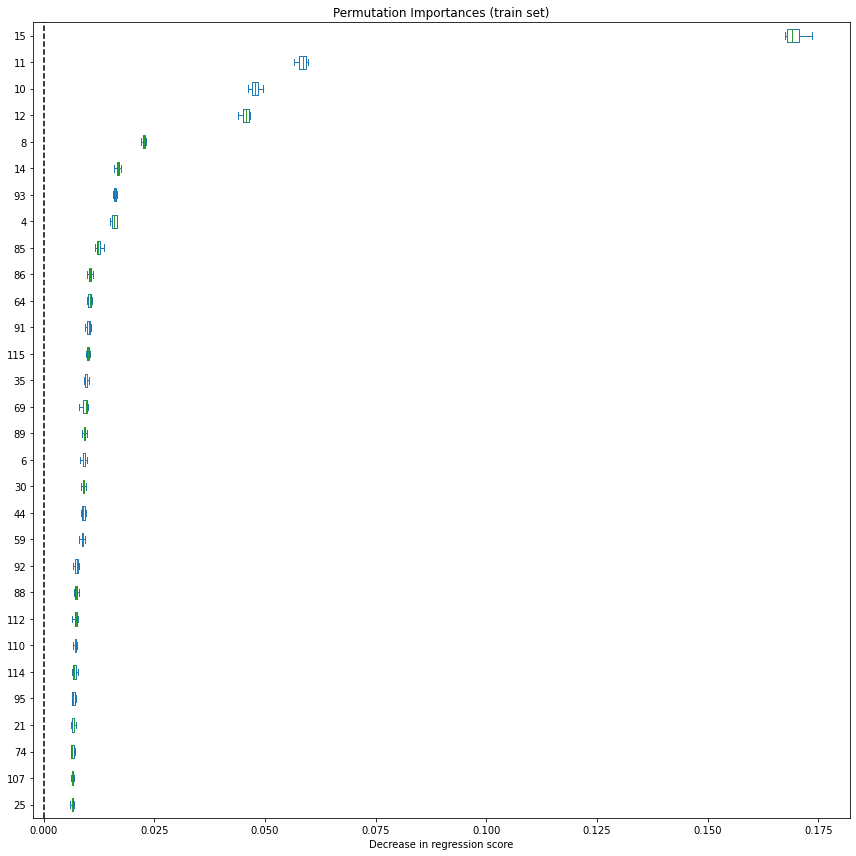

In [307]:
sorted_importances_idx = result.importances_mean.argsort()[-30:]
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=sorted_importances_idx,
)
ax = importances.plot.box(vert=False, whis=10, figsize=(12,12))
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in regression score")
ax.figure.tight_layout()

Random Forest Regressor

In [124]:
rfr.fit(train_X5, train_y)

RandomForestRegressor(max_depth=10, n_estimators=50, oob_score=True)

In [129]:
result_rfr = permutation_importance(
    rfr, train_X5, train_y, n_repeats=10, random_state=11, n_jobs=-1
)

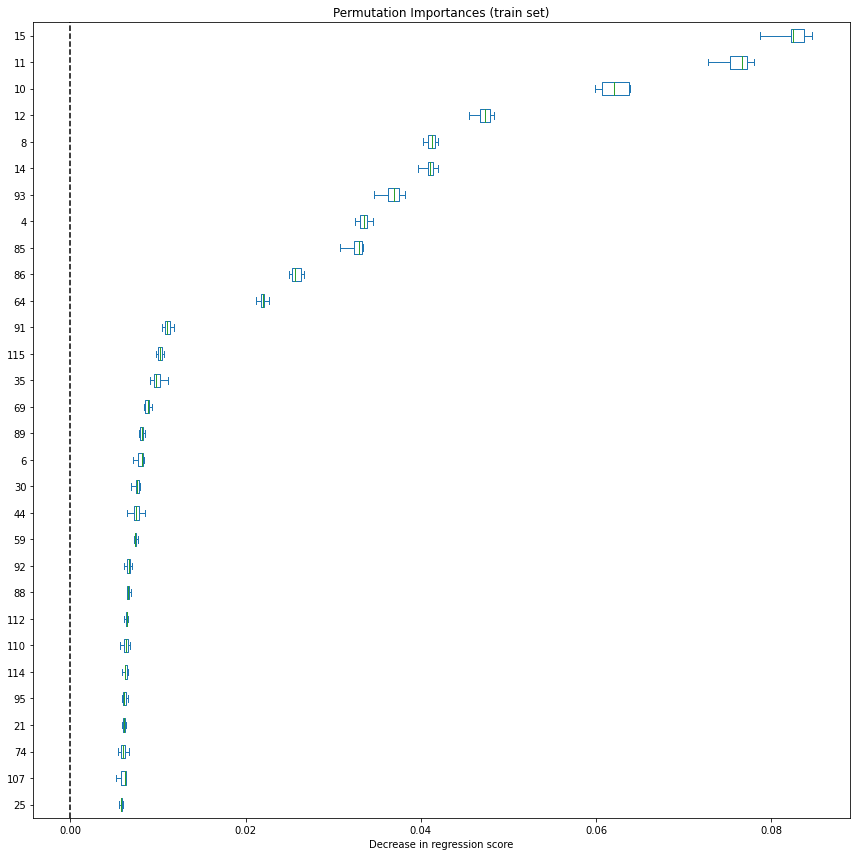

In [306]:
sorted_importances_idx_rfr = result_rfr.importances_mean.argsort()[-30:]
importances_rfr = pd.DataFrame(
    result_rfr.importances[sorted_importances_idx_rfr].T,
    columns=sorted_importances_idx,
)
ax = importances_rfr.plot.box(vert=False, whis=10, figsize=(12,12))
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in regression score")
ax.figure.tight_layout()

In [340]:
set(result_rfr.importances_mean.argsort()[-10:])-set(result.importances_mean.argsort()[-10:])

{20, 43, 63}

In [341]:
set(result_rfr.importances_mean.argsort()[-10:]).intersection(set(result.importances_mean.argsort()[-10:]))

{4, 8, 10, 11, 12, 15, 85}

In [345]:
np.mean(result_rfr.importances_mean.argsort()[-50:]<57)

0.32

Now Let's see if we have a good overlap of features being important across the top performing models.

In [135]:
common_imp_idx = set(result_rfr.importances_mean.argsort()[-50:]).intersection(set(result.importances_mean.argsort()[-50:]))
len(common_imp_idx)

33

In [138]:
top50_across = set(result_rfr.importances_mean.argsort()[-50:]).union(set(result.importances_mean.argsort()[-50:]))

In [374]:
top50_across = np.array(list(top50_across))

Across the 50 most important variables of both the highest performing models, 
- 31% importance lies with complex non-linear interactions of ['publishedDayNum' 'log_duration_secs' 'len_title']
- 12% with ['topicLabel']
- 0% with ['definition']
- 53% with ['word vector dimensions for titles']

In [378]:
np.mean(top50_across<57), np.mean(top50_across>110), np.mean(np.where((top50_across > 108) & (top50_across < 110), True, False)), np.mean(np.where((top50_across > 56) & (top50_across < 108), True, False))

(0.31343283582089554, 0.11940298507462686, 0.0, 0.5373134328358209)

Since we don't have enough data to be able to model complex word relations, let's use the features that make up the top50 of our best performing models and build a regressor for each topicLabel in an attempt to improve the over performance.
Let's also try and explore possible methods of oversampling if it has the possibility to improve predictions.

Experimentation Section

In [ ]:
pf = PolynomialFeatures(2)

In [313]:
train_X5[:,list(common_imp_idx)].shape

(38435, 33)

In [332]:
hgbr33 = HistGradientBoostingRegressor(l2_regularization=0.2, max_depth=10,
                              max_leaf_nodes=50, n_iter_no_change=15)
hgbr33.fit(train_X5, train_y)

HistGradientBoostingRegressor(l2_regularization=0.2, max_depth=10,
                              max_leaf_nodes=50, n_iter_no_change=15)

In [331]:
ret_metrics(hgbr33, train_X5[:,list(top50_across)], train_y)

(1.4362191003016036, 4.534359183921133, 2.129403480771348)

In [334]:
ret_metrics(hgbr33, train_X5, train_y)

(1.2967162949328197, 3.6365882371830507, 1.9069840684135384)

In [324]:
ret_metrics(hgbr33, pf.transform(train_X5[:,list(common_imp_idx)]), train_y)

(1.428352769188765, 4.502482518594222, 2.12190539812552)

In [325]:
pf.transform(test_X5[:,list(common_imp_idx)]).shape

(9622, 595)

In [297]:
from sklearn.decomposition import KernelPCA
X_embedded = KernelPCA(n_components=5, kernel='poly', degree=5).fit_transform(topic_transform_dict_train[cat])

In [240]:
plt.scatter(X_embedded[:, 1], train_y.iloc[topic_df_dict_train[cat].index])


In [ ]:
data_train, data_test = train_test_split(raw_df, test_size=0.20, random_state=42)

data_train = data_train.dropna()
data_test = data_test.dropna()

In [ ]:
# df = create_train_dataset(data_train)
target = create_target(data_train)
train_X = create_train_dataset(data_train, d=4)
target.shape

In [ ]:
test_target = create_target(data_test)

In [ ]:
lr_pipeline = Pipeline([('create_dataset', FunctionTransformer(create_train_dataset)),
          ('ohe', OneHotEncoder(handle_unknown='ignore')),
          ('scale',MaxAbsScaler()),
          ('lr', LinearRegression())]) 

In [ ]:
lr_pipeline.fit(data_train, target)

In [ ]:
filename = 'model.sav'
pickle.dump(lr_pipeline, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.score(data_test, test_target)

In [ ]:
title = "love is in the air"
duration = int("10000")
publishedAt = datetime.datetime.now()
definition = "hd"
topicLabel = "Music"

In [ ]:
featureset = ["title", "duration", "publishedAt", "definition", "topicLabel"]

In [ ]:
user_ip = pd.DataFrame([[title, duration, publishedAt, definition, topicLabel]], columns=featureset)
user_ip

In [ ]:
loaded_model.predict(user_ip)[0]

,title,duration_secs,publishedAt,definition,topicLabel
0,The Milestone 2,120,2022-10-16 15:14:16.117063,hd,Travel


In [ ]:
create_dataset(user_ip, featureset, primary=True)